In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from hera_cal import redcal
import linsolve

In [2]:
Nants = 37

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
antpos = {k:v for k,v in zip(range(37),ants)}
reds = redcal.get_reds(antpos)
redbls = redcal.get_pos_reds(antpos)

In [5]:
reds

[[(0, 5, 'xx'),
  (1, 6, 'xx'),
  (2, 7, 'xx'),
  (3, 8, 'xx'),
  (4, 10, 'xx'),
  (5, 11, 'xx'),
  (6, 12, 'xx'),
  (7, 13, 'xx'),
  (8, 14, 'xx'),
  (9, 16, 'xx'),
  (10, 17, 'xx'),
  (11, 18, 'xx'),
  (12, 19, 'xx'),
  (13, 20, 'xx'),
  (14, 21, 'xx'),
  (15, 22, 'xx'),
  (16, 23, 'xx'),
  (17, 24, 'xx'),
  (18, 25, 'xx'),
  (19, 26, 'xx'),
  (20, 27, 'xx'),
  (22, 28, 'xx'),
  (23, 29, 'xx'),
  (24, 30, 'xx'),
  (25, 31, 'xx'),
  (26, 32, 'xx'),
  (28, 33, 'xx'),
  (29, 34, 'xx'),
  (30, 35, 'xx'),
  (31, 36, 'xx')],
 [(0, 4, 'xx'),
  (1, 5, 'xx'),
  (2, 6, 'xx'),
  (3, 7, 'xx'),
  (4, 9, 'xx'),
  (5, 10, 'xx'),
  (6, 11, 'xx'),
  (7, 12, 'xx'),
  (8, 13, 'xx'),
  (9, 15, 'xx'),
  (10, 16, 'xx'),
  (11, 17, 'xx'),
  (12, 18, 'xx'),
  (13, 19, 'xx'),
  (14, 20, 'xx'),
  (16, 22, 'xx'),
  (17, 23, 'xx'),
  (18, 24, 'xx'),
  (19, 25, 'xx'),
  (20, 26, 'xx'),
  (21, 27, 'xx'),
  (23, 28, 'xx'),
  (24, 29, 'xx'),
  (25, 30, 'xx'),
  (26, 31, 'xx'),
  (27, 32, 'xx'),
  (29, 33, 'xx'),
  

In [4]:
def genA(redbls):
    # number of parameters = num_ants + num_unique baselines
    N = Nants + len(redbls)
    
    # number of measurements = total number of baselines
    allbls = [bl for red in redbls for bl in red]
    M = len(allbls)
    
    A = np.zeros([M,N],dtype=np.complex)
    i = 0
    for bl,reds in enumerate(redbls):
        for pair in reds:
            A[i,pair[0]] = (1+1j)
            A[i,pair[1]] = (1-1j)
            A[i,Nants+bl] = 1+1j
            i += 1
    return np.matrix(A)

A = genA(redbls)
sub_bls = np.array([redbls[0],redbls[1],redbls[2]])
At = genA(sub_bls)

neqs = np.diag(np.dot(np.transpose(A.real),A.real))[:Nants]
neqs_sub = np.diag(np.dot(np.transpose(At.real),At.real))[:Nants]

## Gain covariance (logcal)

In [201]:
Nsim = 1024
sigma = 0.01

gains_input, vis, data = redcal.sim_red_data(reds,shape=(1, Nsim),gain_scatter=0.1)
data = {k:v+sigma*redcal.noise((1, Nsim)) for k,v in data.items()}

redcalibrator = redcal.RedundantCalibrator(reds)
sol_degen = redcalibrator.logcal(data)
sol = redcalibrator.remove_degen(sol_degen, degen_sol=gains_input)

# Minimal
redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])
subsol_degen = redcalibrator_sub.logcal(data)
subsol = redcalibrator_sub.remove_degen(subsol_degen, degen_sol=gains_input)

In [202]:
subgain = []
allgain = []

for ant in range(37):
    allgain.append(np.log(sol[(ant,'Jxx')][0]))
    subgain.append(np.log(subsol[(ant,'Jxx')][0]))
    
print np.mean(np.var(allgain, axis=1))
print np.mean(np.var(subgain, axis=1))

3.15779723760484e-05
0.00022248810340673572


<IPython.core.display.Javascript object>


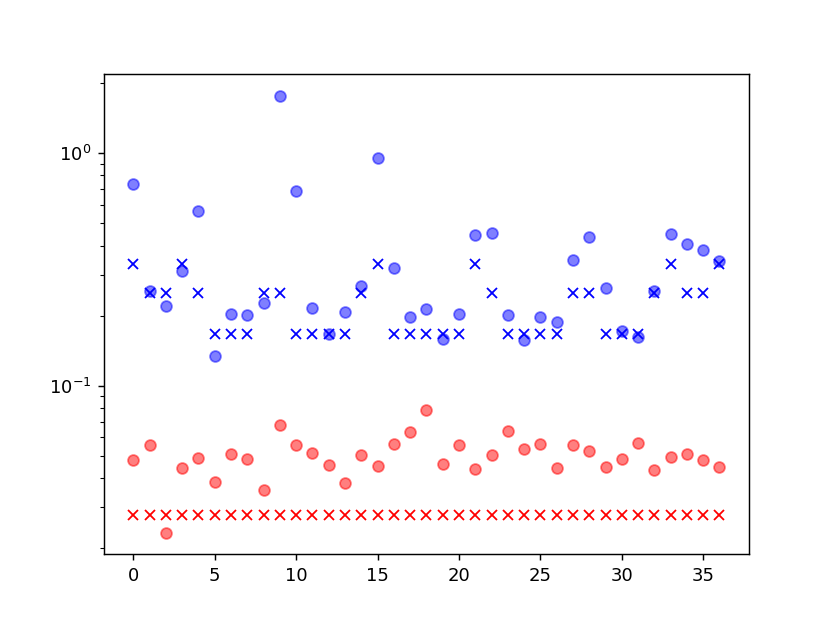

In [203]:
plt.figure()
plt.semilogy(np.var(allgain, axis=1)/(sigma**1.6),'or',alpha=0.5)
plt.semilogy(1/neqs,'.', marker='x',color='r')
plt.semilogy(np.var(subgain, axis=1)/(sigma**1.6), 'ob',alpha=0.5)
plt.semilogy(1/neqs_sub,'.', marker='x',color='b')

# Scaling of gain variance

In [218]:
Nsim = 1024
gains_input, vis, data = redcal.sim_red_data(reds,shape=(1, Nsim),gain_scatter=0.5)

noise = np.logspace(-3,3,num=20)
varsub = []
varall = []

redcalibrator = redcal.RedundantCalibrator(reds)
redcalibrator_sub = redcal.RedundantCalibrator([reds[0],reds[1],reds[2]])

for sigma in noise:    
    data = {k:v+sigma*redcal.noise((1, Nsim)) for k,v in data.items()}

    sol_degen = redcalibrator.logcal(data)
    sol = redcalibrator.remove_degen(sol_degen, degen_sol=gains_input)

    subsol_degen = redcalibrator_sub.logcal(data)
    subsol = redcalibrator_sub.remove_degen(subsol_degen, degen_sol=gains_input)
    
    subgain = []
    allgain = []
    for ant in range(37):
        allgain.append(np.log(sol[(ant,'Jxx')][0]))
        subgain.append(np.log(subsol[(ant,'Jxx')][0]))
        
    varall.append(np.var(allgain, axis=1))
    varsub.append(np.var(subgain, axis=1))

<IPython.core.display.Javascript object>


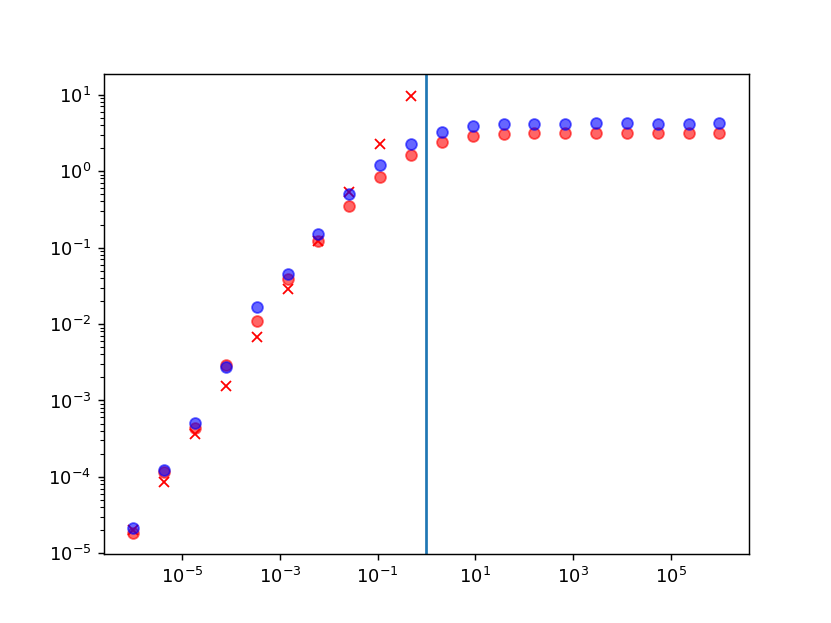

In [227]:
sigma_v = noise**2
knee = 10

plt.figure()
plt.loglog(sigma_v, np.mean(neqs)*np.mean(varall, axis=1), 'or', alpha=0.6)
plt.loglog(sigma_v[:knee], 20*sigma_v[:knee], '.r', marker='x')
#plt.loglog(sigma_v[knee:], [3*1/np.mean(neqs)]*(np.size(noise)-knee), '.r', marker='^')

plt.loglog(sigma_v, np.mean(neqs_sub)*np.mean(varsub, axis=1), 'ob', alpha=0.6)
#plt.loglog(sigma_v[:knee], 2.6*sigma_v[:knee], '.b', marker='x')
#plt.loglog(sigma_v[knee:], [4*1/np.mean(neqs_sub)]*(np.size(noise)-knee), '.b', marker='^')

plt.axvline(x=1)

In [174]:
print np.mean(varall, axis=1)
print np.mean(varsub, axis=1)

[3.96731484e-07 2.01324571e-06 9.11362927e-06 3.90382693e-05
 1.40525661e-04 4.78526330e-04 1.62769943e-03 5.27961851e-03
 1.54871408e-02 3.64369058e-02 6.25025675e-02 7.92559308e-02
 8.53185037e-02 8.62684688e-02 8.69517959e-02 8.75143043e-02
 8.73057554e-02 8.80305212e-02 8.84963892e-02 8.78740490e-02]
[3.67634181e-06 1.92805299e-05 9.84229559e-05 4.69756753e-04
 1.40120143e-03 4.69450644e-03 1.59040230e-02 5.04099249e-02
 1.47241167e-01 3.52759080e-01 6.07672452e-01 7.89052557e-01
 8.44183252e-01 8.64871814e-01 8.58724526e-01 8.63110550e-01
 8.57658451e-01 8.62267960e-01 8.59262794e-01 8.58943353e-01]


In [140]:
s = np.mean(varsub, axis=1)

In [170]:
np.mean(1/neqs_sub)

0.22072072072072071

In [147]:
(a,b) = (4,0)
print (np.log(s[b])-np.log(s[a]))/(np.log(noise[b])-np.log(noise[a]))

2.043358712583389


<IPython.core.display.Javascript object>


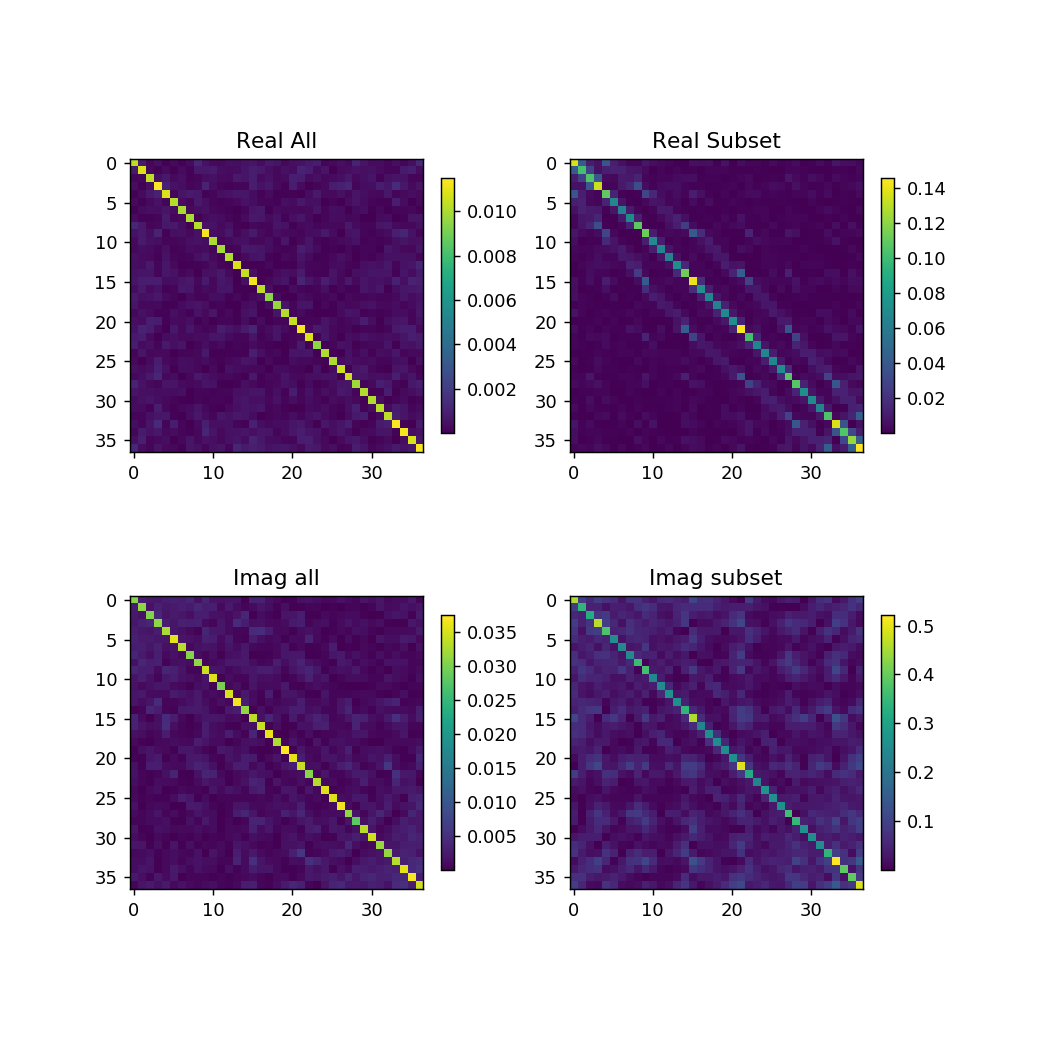

In [34]:
subgain = []
allgain = []

for ant in range(37):
    allgain.append(np.log(sol[(ant,'Jxx')][0]))
    subgain.append(np.log(subsol[(ant,'Jxx')][0]))

subcovr = np.cov(np.real(subgain))
subcovi = np.cov(np.imag(subgain))

allcovr = np.cov(np.real(allgain))
allcovi = np.cov(np.imag(allgain))

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('Real All')
plt.imshow(np.abs(allcovr))
plt.colorbar(shrink=0.7)

plt.subplot(222)
plt.title('Real Subset')
plt.imshow(np.abs(subcovr))
plt.colorbar(shrink=0.7)

plt.subplot(223)
plt.title('Imag all')
plt.imshow(np.abs(allcovi))
plt.colorbar(shrink=0.7)

plt.subplot(224)
plt.title('Imag subset')
plt.imshow(np.abs(subcovi))
plt.colorbar(shrink=0.7)

## Gain covariance averaging (logcal)

<IPython.core.display.Javascript object>


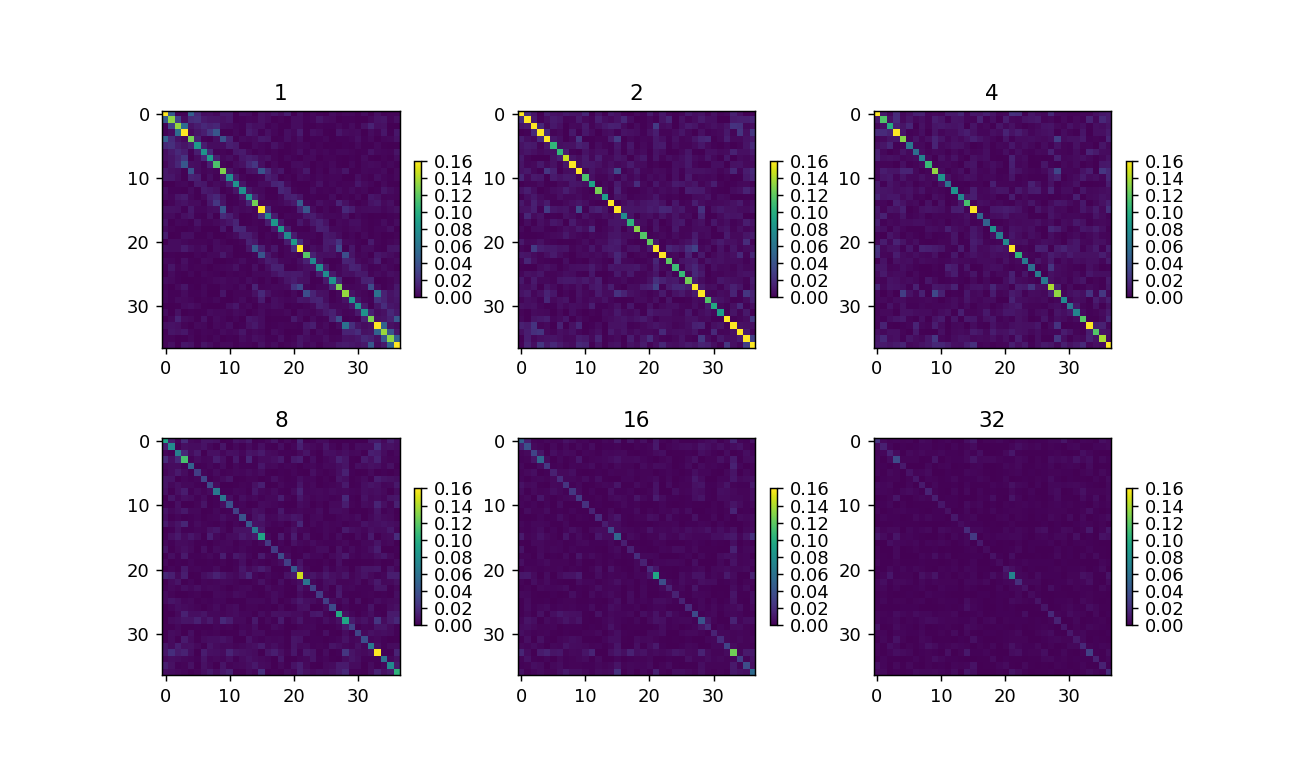

In [5]:
steps = np.logspace(0, int(np.log(Nsim)/np.log(2)), base=2, num=11, dtype=np.int)

g = np.zeros([Nants, Nsim],dtype=np.complex)
for i in range(Nants):
    g[i] = subsol[(i,'Jxx')]
    
fig, ax = plt.subplots(2,3,figsize=(10,6))

for n,i in enumerate(steps[:6]):
    gp = np.sum(g.reshape(37,-1,i),axis=2)*np.sqrt(i)
    cr = np.cov(np.real(np.log(gp))) #np.log(np.abs(gp)))
    
    im = ax[n//3][n%3].imshow(np.abs(cr), vmin=0, vmax=0.16)
    fig.colorbar(im, ax=ax[n//3][n%3], shrink=0.5)
    ax[n//3][n%3].set_title(i)

In [4]:
subredbls = reds[0:3]
subviskeys = [(0,1,'xx'),(0,4,'xx'),(0,5,'xx')]

In [228]:
reds

[[(0, 5, 'xx'),
  (1, 6, 'xx'),
  (2, 7, 'xx'),
  (3, 8, 'xx'),
  (4, 10, 'xx'),
  (5, 11, 'xx'),
  (6, 12, 'xx'),
  (7, 13, 'xx'),
  (8, 14, 'xx'),
  (9, 16, 'xx'),
  (10, 17, 'xx'),
  (11, 18, 'xx'),
  (12, 19, 'xx'),
  (13, 20, 'xx'),
  (14, 21, 'xx'),
  (15, 22, 'xx'),
  (16, 23, 'xx'),
  (17, 24, 'xx'),
  (18, 25, 'xx'),
  (19, 26, 'xx'),
  (20, 27, 'xx'),
  (22, 28, 'xx'),
  (23, 29, 'xx'),
  (24, 30, 'xx'),
  (25, 31, 'xx'),
  (26, 32, 'xx'),
  (28, 33, 'xx'),
  (29, 34, 'xx'),
  (30, 35, 'xx'),
  (31, 36, 'xx')],
 [(0, 4, 'xx'),
  (1, 5, 'xx'),
  (2, 6, 'xx'),
  (3, 7, 'xx'),
  (4, 9, 'xx'),
  (5, 10, 'xx'),
  (6, 11, 'xx'),
  (7, 12, 'xx'),
  (8, 13, 'xx'),
  (9, 15, 'xx'),
  (10, 16, 'xx'),
  (11, 17, 'xx'),
  (12, 18, 'xx'),
  (13, 19, 'xx'),
  (14, 20, 'xx'),
  (16, 22, 'xx'),
  (17, 23, 'xx'),
  (18, 24, 'xx'),
  (19, 25, 'xx'),
  (20, 26, 'xx'),
  (21, 27, 'xx'),
  (23, 28, 'xx'),
  (24, 29, 'xx'),
  (25, 30, 'xx'),
  (26, 31, 'xx'),
  (27, 32, 'xx'),
  (29, 33, 'xx'),
  

## Gain Covariance (lincal)

In [ ]:
Nsim = 256

# Simulate gains and visibilities
true_gains, true_vis, true_data = redcal.sim_red_data(reds, shape=(1, Nsim), gain_scatter=0.1)
data = {k:v+ 0.1*redcal.noise((1, Nsim)) for k,v in true_data.items()}
    
# redcalibrator = redcal.RedundantCalibrator(reds)
# sol_degen = redcalibrator.logcal(data)
# sol_degen = redcalibrator.lincal(data, sol_degen)
# sol = redcalibrator.remove_degen(sol_degen[1], degen_sol= true_gains)

# Minimal
redcalibrator_sub = redcal.RedundantCalibrator(subredbls)
subsol_degen = redcalibrator_sub.logcal(data)
subsol_degen = redcalibrator_sub.lincal(data, subsol_degen)
subsol = redcalibrator_sub.remove_degen(subsol_degen[1], degen_sol= true_gains)

<IPython.core.display.Javascript object>


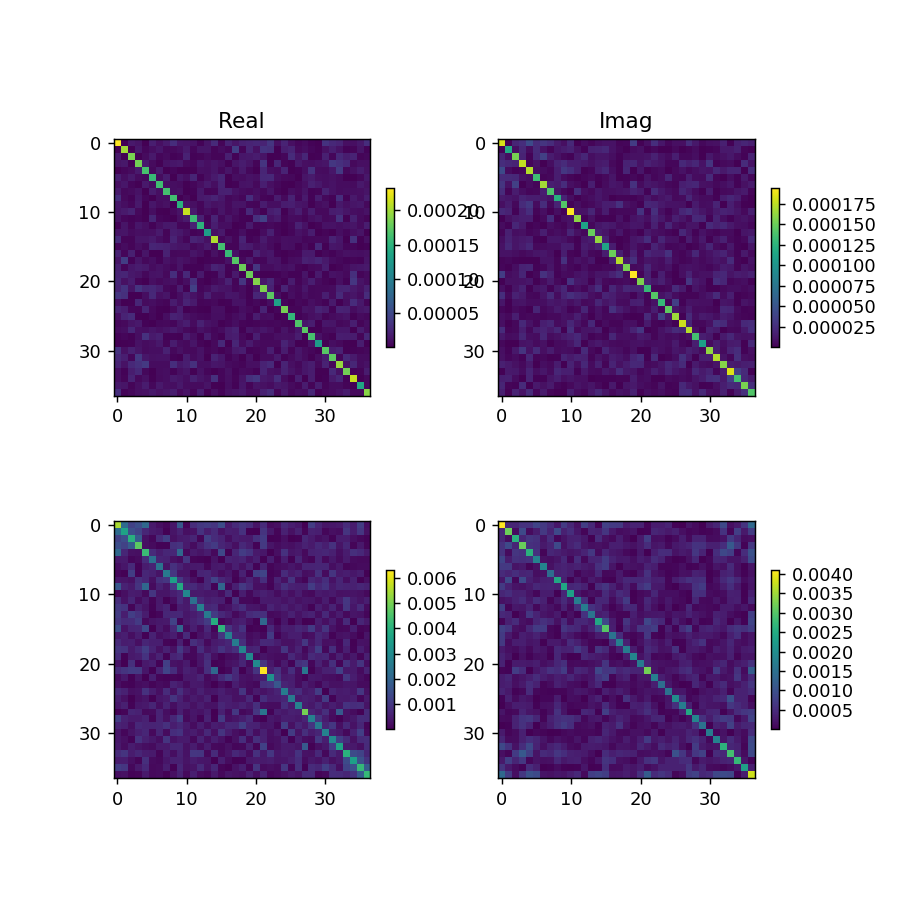

In [9]:
subgain = []
allgain = []

for ant in range(37):
    allgain.append(np.log(sol[(ant,'Jxx')][0]))
    subgain.append(np.log(subsol[(ant,'Jxx')][0]))

subcovr = np.cov(np.real(subgain))
subcovi = np.cov(np.imag(subgain))

allcovr = np.cov(np.real(allgain))
allcovi = np.cov(np.imag(allgain))

plt.figure(figsize=(7,7))
plt.subplot(221)
plt.title('Real')
plt.imshow(np.abs(allcovr))
plt.colorbar(shrink=0.5)

plt.subplot(223)
plt.imshow(np.abs(subcovr))
plt.colorbar(shrink=0.5)

plt.subplot(222)
plt.title('Imag')
plt.imshow(np.abs(allcovi))
plt.colorbar(shrink=0.5)

plt.subplot(224)
plt.imshow(np.abs(subcovi))
plt.colorbar(shrink=0.5)

# Covariance with averaging gain

## Gain covariance averaging (lincal)

The logcal solutions have biased noise- the noise distribution is not gaussian and has a large tail. It is possible that the reduction in covariance structure from moving quickly along this long shallow tail.

Reconstructing the same decrease in covariance structure with lincal will show that the averaging does reduce the gain covariance.

<IPython.core.display.Javascript object>


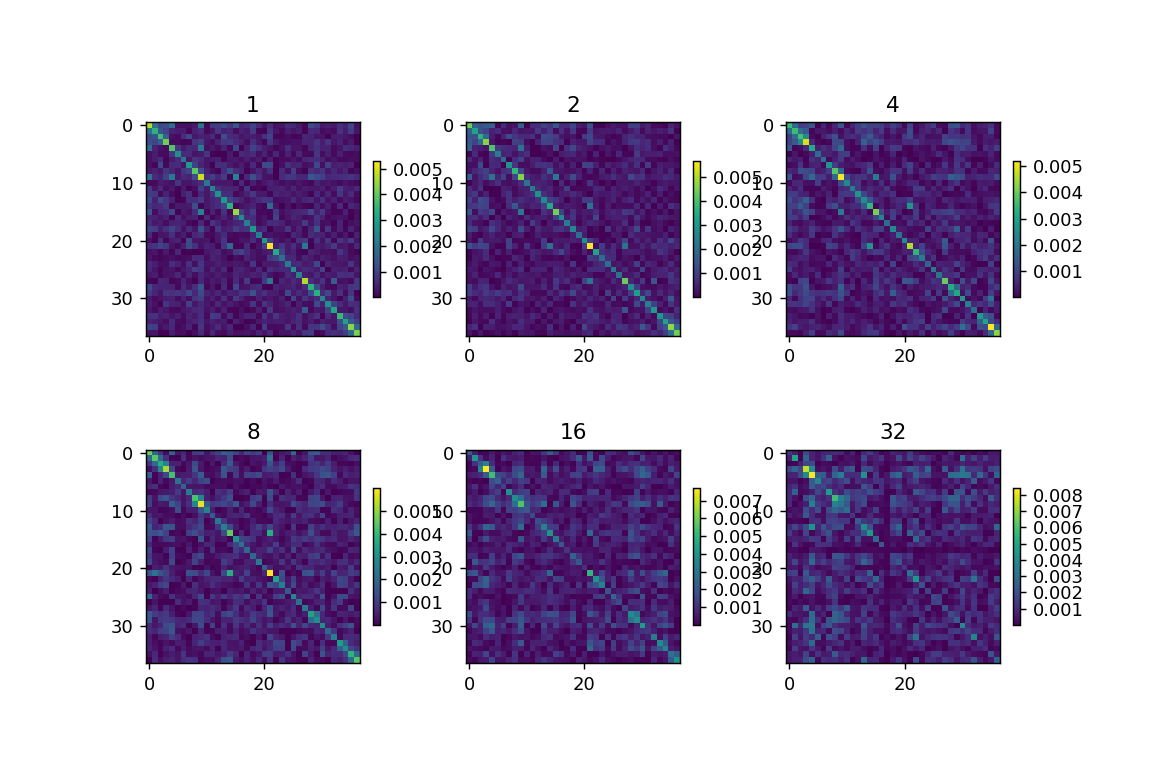

In [11]:
Nsim2 = int(np.log(Nsim)/np.log(2))
steps = np.logspace(0, Nsim2, base=2, num=Nsim2 + 1, dtype=np.int)

g = np.zeros([Nants, Nsim],dtype=np.complex)
for i in range(Nants):
    g[i] = subsol[(i,'Jxx')]
    
fig, ax = plt.subplots(2,3,figsize=(9,6))

for n,i in enumerate(steps[:6]):
    gp = np.mean(g.reshape(Nants,-1,i),axis=2)*np.sqrt(i)
    cr = np.cov(np.real(gp))
    #ci = np.cov(np.imag(gp))
    
    im = ax[n//3][n%3].imshow(np.abs(cr))#, vmin=0,vmax=2.5e-3)
    fig.colorbar(im, ax=ax[n//3][n%3], shrink=0.5)
    ax[n//3][n%3].set_title(i)

# Scatter in All Visibilities

The sub-redcal system does not calibrate over all the redundant baseline sets, so naturally the scatter of the visibilities that have not been conditioned over will be larger. How much?

In [12]:
def calibrate(data,gains):
    calib_data = {}
    for (i, j, pol) in data.keys():
        calib_data[(i, j, pol)] = data[(i, j, pol)]/(gains[(i,'Jxx')] * np.conj(gains[(j,'Jxx')]))
    return calib_data

def average_red_vis(data, gains, subreds):
    sub_bl_visib = calibrate(data, gains)
    vis = 0
    for subbl in subreds:
        vis += sub_bl_visib[subbl]/len(subreds)
    return vis

def optimize_red_vis(data, gains, subreds):
    eqs = {}; startp = {}
    for (i,j,pol) in subreds:
        eqs['g_%d * g_%d_ * V'%(i,j)] = data[(i,j,pol)]
        eqs['g_%d'%(i)] = gains[(i,'Jxx')]
        eqs['g_%d'%(j)] = gains[(j,'Jxx')]
    for i in range(37):
        startp['g_%d'%(i)] = gains[(i,'Jxx')]    
    startp['V'] = average_red_vis(data, gains, subreds)
    
    lps = linsolve.LinProductSolver(eqs,startp)
    X = lps.solve()
    return X['V']

In [13]:
model_vis_sub = {}
for k in true_vis.keys():
    if k in subsol.keys():
        model_vis_sub[k] = subsol[k]
    else:
        subreds = [bls for bls in reds if k in bls][0]
        model_vis_sub[k] = average_red_vis(data, subsol, subreds) #optimize_red_vis(data, subsol, subreds)

In [14]:
sigma = 0.1

chisq_sub = 0; chisq_all = 0

for k in true_vis.keys():
    subreds = [bls for bls in reds if k in bls][0] 
    for (i,j,pol) in subreds:
        chisq_sub += np.abs((subsol[i,'Jxx']*np.conj(subsol[j,'Jxx'])*model_vis_sub[k] -data[(i,j,pol)]))**2
        chisq_all += np.abs((sol[i,'Jxx']*np.conj(sol[j,'Jxx'])*sol[k] -data[(i,j,pol)]))**2
        
chisq_sub = chisq_sub/((666-100+4)*sigma**2)
chisq_all = chisq_all/((666-100+4)*sigma**2)

print chisq_sub[0][0]
print chisq_all[0][0]

1.273483885324553
0.9623695837870798


In [ ]:
plt.figure()
plt.plot(chisq_all[0],'g')
plt.plot(chisq_sub[0],'b')

In [16]:
Nsim2 = int(np.log(Nsim)/np.log(2))

steps = np.logspace(0, Nsim2, base=2, num=Nsim2+1, dtype=np.int)
chisq_sub = np.zeros([Nsim2+1, Nsim])

model_vis_sub = {}

for n,i in enumerate(steps):
    print i
    # (i) Average the gains
    gain_sub = {}
    for k in true_gains.keys():
        gain_sub[k] = np.asarray([np.repeat(np.mean(subsol[k].reshape(-1,i), axis=1), i, axis=0)])

    # (ii) Compute all model visibilities with the averaged gains
    model_vis_sub[n] = {}
    
    for k in true_vis.keys():
        if k in subsol.keys():
            model_vis_sub[n][k] = subsol[k]
        else:
            subreds = [bls for bls in reds if k in bls][0]
            model_vis_sub[n][k] = average_red_vis(data, gain_sub, subreds) #optimize_red_vis(data, gain_sub, subreds)

            
    # (iii) Compute the chisq with these new model visibilities
    for k in true_vis.keys():
        subreds = [bls for bls in reds if k in bls][0] 
        for (a1,a2,pol) in subreds:
            chisq_sub[n] += np.abs((gain_sub[(a1,'Jxx')]*np.conj(gain_sub[(a2,'Jxx')])\
                                    *model_vis_sub[n][k] -data[(a1,a2,pol)])[0])**2

    chisq_sub[n] = chisq_sub[n]/((i*666. - (37+ (63*i)- (4*i)))* sigma**2)

1
2
4
8
16
32
64
128
256


<IPython.core.display.Javascript object>


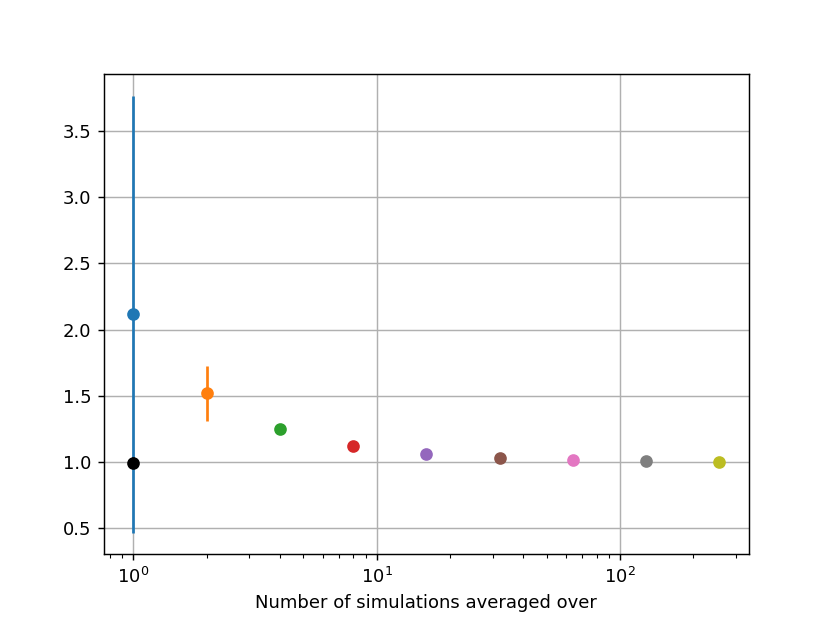

1 2.11680977667482
2 1.5179537846672428
4 1.244959083627
8 1.121377114717392
16 1.0582958378587382
32 1.0264656054525885
64 1.0112913811955755
128 1.003322516693843
256 1.0006028125433588


Text(0,0.5,'')

In [18]:
plt.figure()
for n,i in enumerate(steps):
    chi = np.mean(np.sum(chisq_sub[n].reshape(-1,i),axis=1))
    print i, chi
    plt.errorbar(i, chi, yerr=np.std(chisq_sub[n]), fmt='o')

plt.errorbar(1,np.mean(chisq_all[0]),yerr=np.std(chisq_all[0]),fmt='o',color='k')
plt.grid()
plt.semilogx()
plt.xlabel('Number of simulations averaged over')
plt.ylabel('')

# Chisq changing with baselines

In [19]:
num_redbls = np.arange(3,18,3)
for i in num_redbls:
    redset = reds[0:i]
    print i, len([pair for subbl in redset for pair in subbl])

3 90
6 162
9 231
12 285
15 339


In [20]:
Nsim = 256

# Simulate gains and visibilities
# true_gains, true_vis, true_data = redcal.sim_red_data(reds, shape=(1, Nsim), gain_scatter=0.1)
# data = {k:v+ 0.1*redcal.noise((1, Nsim)) for k,v in true_data.items()}
  
# Solve with all baselines for comparision
redcalibrator = redcal.RedundantCalibrator(reds)
sol_degen = redcalibrator.logcal(data)
sol_degen = redcalibrator.lincal(data, sol_degen)
sol = redcalibrator.remove_degen(sol_degen[1], degen_sol= true_gains)

In [21]:
subsol = {}
for i in num_redbls:
    redset = reds[0:i]
    rc = redcal.RedundantCalibrator(redset)
    sd = rc.logcal(data)
    sd = rc.lincal(data, sd)
    subsol[i] = rc.remove_degen(sd[1], degen_sol= true_gains)

In [22]:
# Compute model visibilities for each
model_vis_sub = {}
for nr in num_redbls:
    model_vis_sub[nr] = {}
    for k in true_vis.keys():
        if k in subsol[nr].keys():
            model_vis_sub[nr][k] = subsol[nr][k]
        else:
            subreds = [bls for bls in reds if k in bls][0]
            model_vis_sub[nr][k] = average_red_vis(data, subsol[nr], subreds)

In [23]:
# Chisq for one simulation
chisq_all = 0
chisq_sub = {}

for k in true_vis.keys():
    subreds = [bls for bls in reds if k in bls][0] 
    for (i,j,pol) in subreds:
        chisq_all += (np.abs((sol[i,'Jxx']*np.conj(sol[j,'Jxx'])*sol[k] -data[(i,j,pol)]))**2)/((666-100+4)*sigma**2)

for nr in num_redbls:
    chisq_sub[nr] = 0
    for k in true_vis.keys():
        subreds = [bls for bls in reds if k in bls][0]
        for (i,j,pol) in subreds:
            chisq_sub[nr] += (np.abs((subsol[nr][i,'Jxx']*np.conj(subsol[nr][j,'Jxx'])*model_vis_sub[nr][k]\
                                     -data[(i,j,pol)]))**2)/((666-100+4)*sigma**2)

print chisq_all[0][0]
for nr in num_redbls:
    redset = reds[0:nr]
    print nr, len([pair for subbl in redset for pair in subbl]), chisq_sub[nr][0][0]

0.9623695837870788
3 90 1.2734838853245514
6 162 1.1518434943710778
9 231 1.0991216364302334
12 285 1.064853260770334
15 339 1.0446428307104378


In [24]:
# Chisq for averaged simulations
Nsim2 = int(np.log(Nsim)/np.log(2))

steps = np.logspace(0, Nsim2, base=2, num=Nsim2+1, dtype=np.int)
chisq_sub     = {}

for nr in num_redbls:
    print "\n", nr, "\t", 
    chisq_sub[nr] = np.zeros([Nsim2+1, Nsim])
    
    for n,savg in enumerate(steps):
        print savg, "\t", 
        
        # (i) Average the gains
        gain_sub = {}
        for k in true_gains.keys():
            gain_sub[k] = np.asarray([np.repeat(np.mean(subsol[nr][k].reshape(-1,savg), axis=1), savg, axis=0)])

        # (ii) Compute all model visibilities with the averaged gains
        model_vis_sub = {}
        for k in true_vis.keys():
            if k in subsol[nr].keys():
                model_vis_sub[k] = subsol[nr][k]
            else:
                subreds = [bls for bls in reds if k in bls][0]
                model_vis_sub[k] = average_red_vis(data, gain_sub, subreds)

        # (iii) Compute the chisq with these new model visibilities
        for k in true_vis.keys():
            subreds = [bls for bls in reds if k in bls][0] 
            for (a1,a2,pol) in subreds:
                chisq_sub[nr][n] += (np.abs((gain_sub[(a1,'Jxx')]*np.conj(gain_sub[(a2,'Jxx')])*model_vis_sub[k]\
                                             -data[(a1,a2,pol)])[0])**2)/((savg*666. - (37+ (63*savg)-\
                                                                                        (4*savg)))* sigma**2)


3 	1 	2 	4 	8 	16 	32 	64 	128 	256 	
6 	1 	2 	4 	8 	16 	32 	64 	128 	256 	
9 	1 	2 	4 	8 	16 	32 	64 	128 	256 	
12 	1 	2 	4 	8 	16 	32 	64 	128 	256 	
15 	1 	2 	4 	8 	16 	32 	64 	128 	256 	

<IPython.core.display.Javascript object>


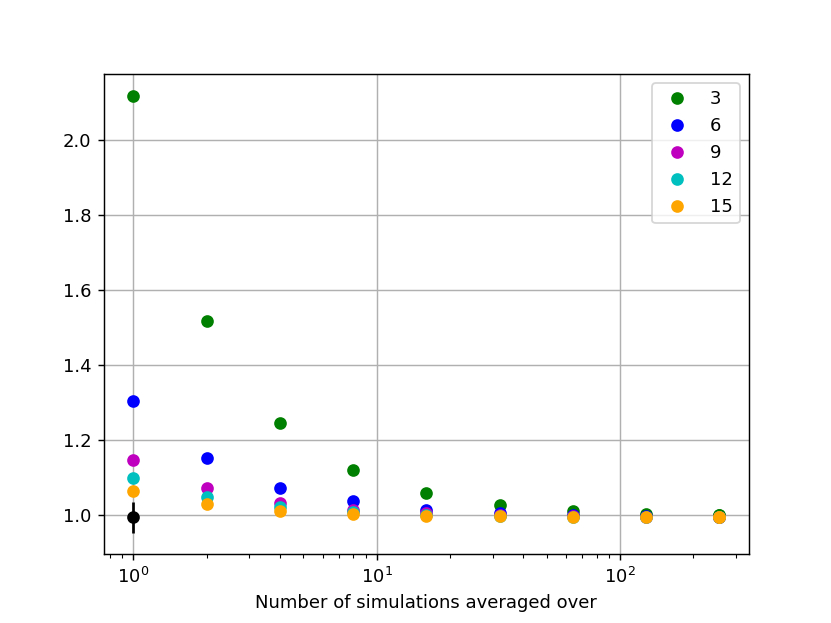

In [25]:
plt.figure()
colors = ['g','b','m','c','orange']
for m,nr in enumerate(num_redbls):
    for n,savg in enumerate(steps):
        chi = np.mean(np.sum(chisq_sub[nr][n].reshape(-1,savg),axis=1))
        #print m, nr, savg, chi
        plt.plot(savg, chi, 'o', color=colors[m])
    plt.plot(savg, chi, 'o', color=colors[m], label=nr)

plt.errorbar(1,np.mean(chisq_all[0]),yerr=np.std(chisq_all[0]),fmt='o',color='k')
plt.grid()
plt.semilogx()
plt.xlabel('Number of simulations averaged over')
plt.ylabel('')
plt.legend()

# Error in Model_Vis contributed by Error in Gain

In [ ]:
def error_from_gains(ant0, ant1, estimated_gains, true_gains, measured_vis, model_vis, true_vis, avg=1):
    g0 = np.average(estimated_gains[(ant0,'Jxx')].reshape(-1,avg),axis=1)[0]
    g1 = np.average(estimated_gains[(ant1,'Jxx')].reshape(-1,avg),axis=1)[0]
    
    # Error in model visibilities
    vis = true_vis[(ant0,ant1,'xx')][0][0]
    err_vis = model_vis_sub[int(np.log(avg)/np.log(2))][(ant0,ant1,'xx')][0][0] - vis
    
    # Error in estimated gains
    err_g0 = g0 - (true_gains[(ant0,'Jxx')][0][0])
    err_g1 = g1 - (true_gains[(ant1,'Jxx')][0][0])
    
    # Error contributed by error in estimated gains alone:
    err_measured_vis_due_to_gains = \
    g0*np.conj(err_g1)*vis+ \
    err_g0*np.conj(g1)*vis+ \
    g0*np.conj(err_g1)*err_vis + \
    err_g0*np.conj(g1)*err_vis + \
    err_g0*np.conj(err_g1)*vis + \
    err_g0*np.conj(err_g1)*err_vis
    
#     print np.shape(g0), np.shape(err_g0), np.shape(g1), np.shape(err_g1), np.shape(err_vis), \
#           np.shape(vis)
    
    return err_measured_vis_due_to_gains

In [ ]:
err = {}
for n,i in enumerate(steps):
    err[i] = error_from_gains(0,1,subsol,true_gains, data, model_vis_sub, true_vis, avg=i)

In [ ]:
plt.figure()
for k in [1,2,4,8,16,32,64,128,256,512,1024]:
    plt.plot(k,np.abs(err[k]),'o')

In [ ]:
error_from_gains(0,1,subsol,true_gains, data, model_vis_sub, true_vis, avg=2)

In [ ]:
# Total error on reconstructed measurements: 1st order
true_gains[(0,'Jxx')]*np.conj(true_gains[(1,'Jxx')])*err_vis[(0,1,'xx')]+ \
true_gains[(0,'Jxx')]*np.conj(err_gain[(1,'Jxx')])*true_vis[(0,1,'xx')]+ \
err_gain[(0,'Jxx')]*np.conj(true_gains[(1,'Jxx')])*true_vis[(0,1,'xx')]

In [ ]:
# Total error on reconstructed measurements: 2nd order
true_gains[(0,'Jxx')]*np.conj(err_gain[(1,'Jxx')])*err_vis[(0,1,'xx')] + \
err_gain[(0,'Jxx')]*np.conj(true_gains[(1,'Jxx')])*err_vis[(0,1,'xx')] + \
err_gain[(0,'Jxx')]*np.conj(err_gain[(1,'Jxx')])*true_vis[(0,1,'xx')]

In [ ]:
# Total error on reconstructed measurements: 3rd order
err_gain[(0,'Jxx')]*np.conj(err_gain[(1,'Jxx')])*err_vis[(0,1,'xx')]

In [ ]:
# Error on measured visibilities
error_measured_vis = data[(0,1,'xx')] - true_vis[(0,1,'xx')]

In [ ]:
# Error contributed by error in estimated gains alone:
err_measured_vis_due_to_gains = true_gains[(0,'Jxx')]*np.conj(err_gain[(1,'Jxx')])*true_vis[(0,1,'xx')]+ \
err_gain[(0,'Jxx')]*np.conj(true_gains[(1,'Jxx')])*true_vis[(0,1,'xx')]+ \
true_gains[(0,'Jxx')]*np.conj(err_gain[(1,'Jxx')])*err_vis[(0,1,'xx')] + \
err_gain[(0,'Jxx')]*np.conj(true_gains[(1,'Jxx')])*err_vis[(0,1,'xx')] + \
err_gain[(0,'Jxx')]*np.conj(err_gain[(1,'Jxx')])*true_vis[(0,1,'xx')] + \
err_gain[(0,'Jxx')]*np.conj(err_gain[(1,'Jxx')])*err_vis[(0,1,'xx')]
print err_measured_vis_due_to_gains

In [ ]:
# Fraction of error in measured visibilities contributed by error in gains
np.abs(error_measured_vis - err_measured_vis_due_to_gains)/np.abs(error_measured_vis)

In [ ]:
# averaged gain
g0 = np.sum(subsol[(0,'Jxx')].reshape(-1,2),axis=1)
g1 = np.sum(subsol[(1,'Jxx')].reshape(-1,2),axis=1)

# Graveyard

In [ ]:
plt.figure()
for k in true_gains.keys():
    gain_dev = subsol[k] - true_gains[k]
    r3 = np.sqrt(np.mean(np.abs(gain_dev)**2))

    dev = []

    for n in steps:
        r = np.mean(gain_dev.reshape(-1,n),axis=-1)
        r2 = np.sqrt(np.mean(np.abs(r)**2))
        dev.append(r2)
        
    plt.loglog(steps,dev/r3,'o-',alpha=0.5)
    plt.plot(steps,1/np.sqrt(steps),'o-',lw=2)

In [ ]:
gain_dev = np.zeros([11,Nsim],dtype=np.complex)
gain_exp_dev = np.zeros([11,Nsim])

for n,i in enumerate(steps):
    gain_sub = {}
    for k in true_gains.keys():
        # Compute the averaged gains for this antenna
        gain_sub[k] = np.asarray([np.repeat(np.mean(subsol[k].reshape(-1,i), axis=1), i, axis=0)])
        # Check how much it deviates from the true vis- add it to the total deviation
        gain_dev[n] += (gain_sub[k] - true_gains[k])[0]
        # Compute how much it should deviate
        #gain_exp_dev[n] +=  
        

# redcal_gain_dev = np.zeros(Nsim)
# for k in true_gains.keys():
#     redcal_gain_dev += np.abs((sol[k] - true_gains[k])[0])**2

In [ ]:
plt.figure()
plt.plot(steps, np.mean(gain_dev,axis=1),'o-')
#plt.plot(1,np.mean(redcal_gain_dev),'ok')
plt.grid()

In [ ]:
# Compare for only one antenna
gain_dev = np.zeros([11,Nsim],dtype=np.complex128)
gain_exp_dev = np.zeros([11,Nsim],dtype=np.complex128)

k = (20,'Jxx')
for n,i in enumerate(steps):
    gain_sub = np.asarray([np.repeat(np.mean(subsol[k].reshape(-1,i), axis=1), i, axis=0)])
    gain_dev[n] = np.asarray(gain_sub-true_gains[k])[0]
    gain_exp_dev[n] = np.abs(np.asarray(gain_sub-true_gains[k])[0])**2
    
plt.figure()
plt.loglog(steps, np.abs(np.mean(gain_dev,axis=1)), 'o', label='Gain deviation')
#plt.loglog(steps, np.sqrt(np.mean(gain_exp_dev,axis=1)/steps), 'o', label='Expected deviation')
plt.legend()

In [ ]:
keys = [k for k in subsol.keys() if len(k) == 2]
res = [subsol[k] - true_gains[k] for k in keys]
ants = [k[0] for k in keys]
avg = [np.abs(np.average(r[:512])) for r in res]
err = [np.sqrt(np.average(np.abs(r[:512])**2) / r.size) for r in res]

plt.figure()
_ = plt.semilogy(ants, avg, '.', label=' <$x-x_0$>')
_ = plt.semilogy(ants, err, 'x', label=' $\sigma$')

In [ ]:
plt.figure()
plt.plot(np.abs(np.mean(gain_dev,axis=1)))

In [ ]:
plt.figure()
plt.loglog(steps, np.mean(gain_dev, axis=1),'o-')
#plt.plot(1,np.mean(redcal_gain_dev),'ok')
plt.grid()

In [ ]:
vis_dev = np.zeros([11,Nsim])
for n,i in enumerate(steps):
    for k in true_vis.keys():
        vis_dev[n] += np.abs((model_vis_sub[n][k]-true_vis[k])[0])**2
        
redcal_vis_dev = np.zeros(Nsim)
for k in true_vis.keys():
    redcal_vis_dev += np.abs((sol[k]-true_vis[k])[0])**2

In [ ]:
plt.figure()
plt.loglog(steps, np.mean(vis_dev, axis=1),'o-')
plt.plot(1,np.mean(redcal_vis_dev),'ok')
plt.grid()

In [ ]:
np.shape(true_gains[(0,'Jxx')])

# Model visiblities

The model visibilities are optimized over when you solve for all the redundant baselines instead of the shortest. So for subredcal, you need to compute all the model visibilities by averaging over the redundant baselines yourself. This estimate will (obviously) be more erroneous than when you optimized over all of them.

In [ ]:
model_vis_all = {}
for k in true_vis.keys():
    subreds = [bls for bls in reds if k in bls][0]
    model_vis_all[k] = 0
    for subbl in subreds:
        model_vis_all[k] += all_bl_visib[subbl]/len(subreds)
    print k,
    print np.mean(np.abs(model_vis_all[k]-sol[k]))

In [ ]:
from matplotlib.patches import Circle,Wedge
from matplotlib.collections import PatchCollection

fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.set_aspect('equal')
ax.axvline()
ax.axhline()
ax.set_xlabel('Re(V)')
ax.set_ylabel('Im(V)')
for i,k in enumerate(true_vis.keys()):
    subreds = [bls for bls in reds if k in bls][0]

    redsol_allbl = []; redsol_subbl = []; reddata = []

    for subbl in subreds:
        # Get variance of solutions
        redsol_allbl.append(np.abs(all_bl_visib[subbl]-true_vis[k]))
        redsol_subbl.append(np.abs(sub_bl_visib[subbl]-true_vis[k]))
        reddata.append(np.abs(data[subbl]-true_vis[k]))

        # Plot initial data, full solution and sub solution
#         ax.plot(np.mean(np.real(data[subbl])), np.mean(np.imag(data[subbl])), 'co', alpha=0.2)
#         ax.plot(np.mean(np.real(all_bl_visib[subbl])),np.mean(np.imag(all_bl_visib[subbl])), 
#                 'g^', alpha=0.5, markersize=5)
#         ax.plot(np.mean(np.real(sub_bl_visib[subbl])),np.mean(np.imag(sub_bl_visib[subbl])),
#                 'mo', alpha=0.5, markersize=5)

    # Draw a circle around max variance
    vis_r, vis_i = np.real(true_vis[k]), np.imag(true_vis[k])
    mean_std_all = np.sqrt(np.mean(np.std(redsol_allbl,axis=0)**2))
    mean_std_sub = np.sqrt(np.mean(np.std(redsol_subbl,axis=0)**2))
    mean_std_data = np.sqrt(np.mean(np.std(reddata, axis=0)**2))
    
    circ1 = plt.Circle((vis_r, vis_i),radius= mean_std_all,  color='g',fill=False); ax.add_patch(circ1)
    circ2 = plt.Circle((vis_r, vis_i),radius= mean_std_sub,  color='m',fill=False); ax.add_patch(circ2)
    circ3 = plt.Circle((vis_r, vis_i),radius= mean_std_data, color='k',fill=False); ax.add_patch(circ3)

    w = Wedge((vis_r[0][0],vis_i[0][0]), mean_std_sub, 
              theta1= 0, theta2= 360, width=(mean_std_sub- mean_std_all), alpha=0.5)
    ax.add_patch(w)

    # Plot true solution
    ax.plot(vis_r, vis_i, 'ks', alpha=0.5, markersize=1)

    # Annotate with number of redundant measurements
    ax.annotate('%d'%len(subreds),(vis_r+0.02, vis_i+0.02))

# Chi-squared per degrees of freedom

$$\chi^2 = \frac{1}{M-N}\Sigma_{all bl} \frac{|g_i g_j^* V_{model} - V_{obs}|^2}{\sigma^2}$$

In [ ]:
# Compute all model visibilities
model_vis_sub ={}

for k in true_vis.keys():
    if k in subsol.keys():
        model_vis_sub[k] = subsol[k]
        continue
    subreds = [bls for bls in reds if k in bls][0]
    model_vis_sub[k] = 0
    for subbl in subreds:
        model_vis_sub[k] += sub_bl_visib[subbl]/len(subreds)

In [ ]:
plt.figure()
#plt.plot(np.real(vis[0]),'o',label='optimizer')
#plt.plot(np.abs(subsol[(0,9,'xx')][0]),'or',label='redcalibrator',alpha=0.5)
#plt.plot(np.abs(data[(0,5,'xx')][0]),'o',label='data')
#plt.plot(np.real(model_vis_sub[(0,5,'xx')][0]),'oy',label='averaging',alpha=0.5)
plt.plot(np.abs(model_vis_sub[(0,9,'xx')][0])-np.abs(vis[0]))
plt.legend()

In [ ]:
subreds

# Average over gains

Does averaging over the gains reduce the $\chi^2$ for *subredcal*?

In [ ]:
plt.figure()
for i in steps:
    gain_sub = {}
    dev = 0
    for k in true_gains.keys():
        gain_sub[k] = np.mean(subsol[k].reshape(-1,i), axis=1)
        dev += np.abs(gain_sub[k]-true_gains[k])**2
    plt.plot(i,dev[0][0],'o')

In [ ]:
mean = 0
plt.figure()
for i in range(37):
    plt.plot(i,np.abs(gain_sub[(i,'Jxx')][0][0] - true_gains[(i,'Jxx')]),'ok')
    plt.plot(i,np.abs(gain_sub[(i,'Jxx')][0][0] - true_gains[(i,'Jxx')]),'ok')

In [ ]:
gain_sub[(0,'Jxx')][0][0]

# Groupings

## Seven Antenna Subsection

Instead of a subset of baselines if I consider a group of 7 antennas, will the covariance be better or worse?